#Tugas Akhir DL: Neural Style Transfer


*   Fatha Marvin Yudhakusuma
*   Muhammad Mahdi
*   Alleludo Panji Dewa Atmaja
*   Bagus Arif Arikusworo



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###Import Libraries

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

###Download Dataset

In [ ]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)
extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

#####Train Image Example

In [ ]:
from IPython.display import Image, display

image_path = "./coco_train2017/train2017/000000000009.jpg"  # Replace with the actual path to the image you want to display
display(Image(filename=image_path))

#####Validation Image Example

In [ ]:
image_path = "./coco_val2017/val2017/000000000139.jpg"  # Replace with the actual path to the image you want to display
display(Image(filename=image_path))

### Membuat Pengurai Data
Kumpulan data COCO menyimpan anotasi dalam file JSON. Untuk mengurai file-file ini, kita perlu memuatnya ke dalam memori dan mengekstrak informasi yang relevan.

In [ ]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

### Visualisasikan Data

In [ ]:
coco_annotations_file="./coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="./coco_val2017/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)

    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()

#Pre Processing

###Resize

In [ ]:
import os
import multiprocessing
import cv2
import shutil
from tqdm import tqdm

def resize_image(args):
    input_path, output_path, target_size = args
    try:
        img = cv2.imread(input_path)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(output_path, img)
    except Exception as e:
        print(f"Error resizing {input_path}: {e}")

def resize_coco_dataset(input_dir, output_dir, target_size=(512, 512), max_workers=8):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    input_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, file)
                input_files.append((input_path, output_path, target_size))

    with multiprocessing.Pool(max_workers) as pool:
        list(tqdm(pool.imap(resize_image, input_files), total=len(input_files), desc="Resizing"))

    # Delete the original input directory after successful resizing
    try:
        shutil.rmtree(input_dir)
    except Exception as e:
        print(f"Error deleting {input_dir}: {e}")

# Example usage:
input_train_dir = "./coco_train2017"
input_val_dir = "./coco_val2017"
output_train_dir = "./resized_coco_train2017"
output_val_dir = "./resized_coco_val2017"

resize_coco_dataset(input_train_dir, output_train_dir)
resize_coco_dataset(input_val_dir, output_val_dir)

In [ ]:
from IPython.display import Image

image_path = "/content/resized_coco_train2017/000000000009.jpg"  # Replace with the actual path to the image you want to display
Image(filename=image_path)

###Augmentation (masi error)


In [ ]:
import os
import random
import shutil
import multiprocessing
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

def augment_image(args):
    input_path, output_path, seq = args
    try:
        img = cv2.imread(input_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = seq.augment_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, img)
    except Exception as e:
        print(f"Error augmenting {input_path}: {e}")

def augment_coco_dataset(input_dir, output_dir, augmentation_ratio=0.1, max_workers=8):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    input_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, file)
                input_files.append((input_path, output_path))

    num_augmented_files = int(len(input_files) * augmentation_ratio)
    input_files = random.sample(input_files, num_augmented_files)

    sometimes = lambda aug: iaa.Sometimes(0.85, aug)
    seq = iaa.Sequential(
        [
            iaa.SomeOf((0, 5),
                       [   iaa.Grayscale(alpha=(0.0, 1.0)),
                           iaa.Fliplr(0.5),
                           iaa.Flipud(0.5),
                           sometimes(iaa.Crop(percent=(0, 0.1))),
                           sometimes(iaa.Affine(
                               scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                               translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                               rotate=(-45, 45),
                               shear=(-16, 16),
                               order=[0, 1],
                               cval=(0, 255),
                               mode=ia.ALL
                           )),
                           ],
                         random_order=True
                         )
        ],
        random_order=True
    )

    input_files = input_files[:int(len(input_files) * augmentation_ratio)]
    with multiprocessing.Pool(max_workers) as pool:
        list(tqdm(pool.imap(augment_image, [(input_path, output_path, seq) for input_path, output_path in input_files]), total=len(input_files), desc="Augmenting"))

# Example usage:
input_train_dir = "./resized_coco_train2017"
input_val_dir = "./resized_coco_val2017"
output_train_dir = "./resized_and_augmented_coco_train2017"
output_val_dir = "./resized_and_augmented_coco_val2017"

augment_coco_dataset(input_train_dir, output_train_dir, augmentation_ratio=0.5)
augment_coco_dataset(input_val_dir, output_val_dir, augmentation_ratio=0.5)

In [ ]:
from IPython.display import Image

image_path = "/content/resized_and_augmented_coco_train2017/000000048384.jpg"  # Replace with the actual path to the image you want to display
Image(filename=image_path)

In [ ]:
import os

def rename_files(folder_path):
    files = os.listdir(folder_path)
    files.sort()
    count = 1
    for file_name in files:
        if os.path.isfile(os.path.join(folder_path, file_name)):
            new_name = f"aug_{count}.png"  # Change the extension to the appropriate one if needed
            os.rename(os.path.join(folder_path, file_name), os.path.join(folder_path, new_name))
            count += 1

# Provide the folder path
folder_path_train = "./resized_and_augmented_coco_train2017"
folder_path_val = "./resized_and_augmented_coco_val2017"

rename_files(folder_path_train)
rename_files(folder_path_val)

In [ ]:
# import os
# import shutil

# def move_and_delete_files(source_folder, destination_folder):
#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)

#     files = os.listdir(source_folder)
#     for file_name in files:
#         source_path = os.path.join(source_folder, file_name)
#         if os.path.isfile(source_path):
#             destination_path = os.path.join(destination_folder, file_name)
#             if os.path.exists(source_path):
#                 try:
#                     shutil.move(source_path, destination_path)
#                     os.remove(source_path)
#                 except FileNotFoundError:
#                     print(f"File {file_name} not found. Skipping...")
#             else:
#                 print(f"File {file_name} not found in {source_folder}. Skipping...")


# # Source and destination folders
# source_folder_train = "./resized_coco_train2017"
# destination_folder_train = "./resized_and_augmented_coco_train2017"

# source_folder_val = "./resized_coco_val2017"
# destination_folder_val = "./resized_and_augmented_coco_val2017"

# move_and_delete_files(source_folder_train, destination_folder_train)
# move_and_delete_files(source_folder_val, destination_folder_val)

In [ ]:
import shutil
import os

def move_png_files_and_delete_folder(src_folder, dest_folder):
    # Ensure destination folder exists, create if not
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of all files in the source folder
    files = os.listdir(src_folder)

    # Filter PNG files
    png_files = [file for file in files if file.lower().endswith('.png')]

    # Move PNG files to the destination folder
    for png_file in png_files:
        src_path = os.path.join(src_folder, png_file)
        dest_path = os.path.join(dest_folder, png_file)
        shutil.move(src_path, dest_path)
        print(f"Moved {png_file} to {dest_folder}")

    # Delete original files in the source folder
    for png_file in png_files:
        file_path = os.path.join(src_folder, png_file)
        os.remove(file_path)
        print(f"Deleted {file_path}")

    # Delete the source folder
    shutil.rmtree(src_folder)
    print(f"Deleted folder: {src_folder}")

# Provide the source and destination folder paths
source_folder_train = "./resized_coco_train2017"
destination_folder_train = "./resized_and_augmented_coco_train2017"

source_folder_val = "./resized_coco_val2017"
destination_folder_val = "./resized_and_augmented_coco_val2017"

move_png_files_and_delete_folder(source_folder_train, destination_folder_train)
move_png_files_and_delete_folder(source_folder_val, destination_folder_val)

###Filter

# Model

### Model menggunakan Keras

Import Keras

In [ ]:
from tensorflow.keras.models import Model as mo
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow import keras
import PIL.Image
import numpy as np

In [ ]:
import tensorflow as tf

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Kita akan menggunakan CNN VGG19 untuk training CNN dengan include_top False agar Softmax layer akhir menjadi classifier 1000 class

In [ ]:
from tensorflow.keras.applications import VGG19
model = VGG19(weights="imagenet", include_top=False)

Lalu, dibuatkan dictionary untuk semua kunci sebagai nama layer dan nilai sebagai layer output

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [ ]:
print()
for layer in model.layers:
  print(layer.name)

Terakhir, model didefinisikan dengan input sesuai spesifikasi VGG19 dan output sesuai dictionary per layer

In [ ]:
feature_extractor = mo(inputs=model.inputs, outputs=outputs_dict)

Selanjutnya adalah mendefinisikan konten dan style karakteristik

In [ ]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layers = "block5_conv2"

In [ ]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# content_path = "/content/resized_coco_val2017/000000000776.jpg" "sesuaikan"
# style_path = "/content/resized_and_augmented_coco_val2017/aug_103.png" "atau ganti model style lain"
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


content_path = "/content/drive/MyDrive/NST/anggit.jpg"
style_path = "/content/drive/MyDrive/NST/style1.jpeg"

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

c_image = load_img(content_path)
s_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(c_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(s_image, 'Style Image')

plt.show()


In [ ]:
# code ini jalan pas aku coba di input gambar lain , tpi karena gambar di sni blm bs blm ku run

def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(s_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

In [ ]:
#mengubah definisi string menjadi sebuah daftar atau list

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layers = ["block5_conv2"]

### Gram Matrix

Jadi untuk gaya komputasi biaya kita tidak boleh membandingkan aktivasi secara langsung. sebaliknya kita akan mendapatkan tensor baru yang berisi gaya aktivasi dan kita dapat melakukan penghitungan biaya yang serupa dengan biaya konten. Sehingga tensor baru tersebut tidak lain hanyalah matriks gram

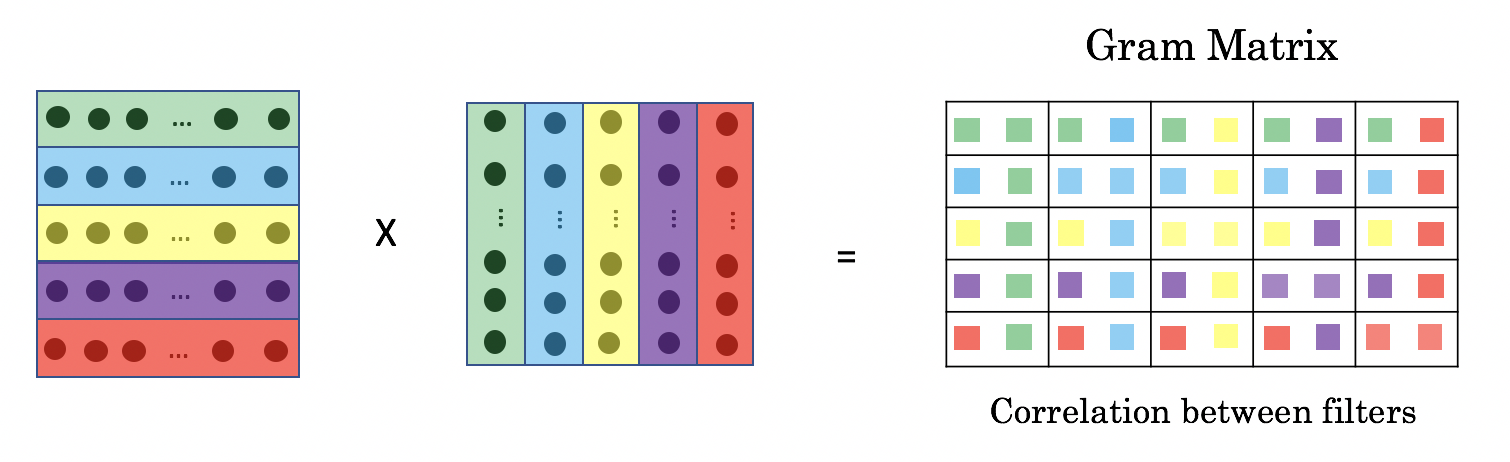

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Style Content Loss

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(c_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

In [ ]:
style_targets = extractor(s_image)['style']
content_targets = extractor(c_image)['content']

image = tf.Variable(c_image)



In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### Optimizer

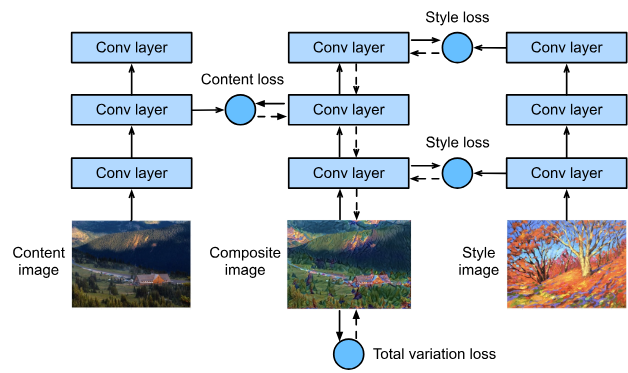

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

### Total Cost

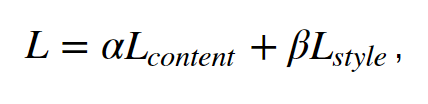

Loss gaya komputasi sedikit berbeda. Loss konten memberikan hasil matematis yang menunjukkan betapa miripnya kedua gambar ini. Semakin mirip berarti semakin menuju nol

Namun gaya komputasi memberikan hasil matematis yang menunjukkan betapa miripnya fitur atau gaya dibandingkan kontennya.

Itu sebabnya total loss memberikan kesalahan dengan menggunakan kedua loss tersebut. Loss konten menghitung untuk menentukan seberapa mirip gambar-gambar itu, apa pun warnanya, gaya Loss gaya menghitung untuk menentukan seberapa mirip gaya gambar satu sama lain daripada konten. Misalnya. Gaya font a dan b --> loss gaya huruf a dan b --> loss konten

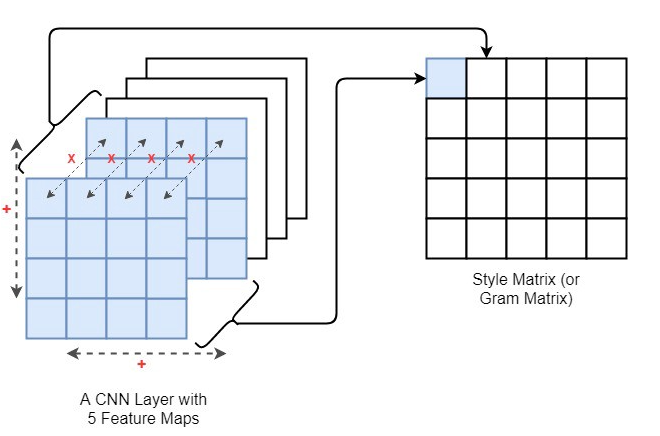

Disini Style loss menggunakan matrix gram. Matriks Gram mengukur distribusi fitur pada peta fitur dalam sebuah lapisan, meminimalkan hilangnya gaya dengan mempertahankan tingkat distribusi fitur yang sama pada gaya dan gambar yang dihasilkan.

Content Loss: CNN secara efisien menangkap konten yang diinginkan dalam gambar yang dihasilkan dengan berfokus pada informasi jaringan tingkat tinggi dan nilai piksel individual pada tingkat yang lebih rendah. Fungsi reduksi_sum menghitung jumlah elemen di seluruh parameter, membandingkan masukan dan gambar yang dihasilkan.

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
from IPython import display
import IPython
from IPython.display import clear_output

### Training

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
pip install streamlit


In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the style transfer model and define necessary functions
from your_model_script import StyleContentModel, tensor_to_image, train_step, clip_0_1

# Assuming the 'extractor' model and related functions are defined in your_model_script.py

# Load the model
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layers = ["block5_conv2"]
extractor = StyleContentModel(style_layers, content_layers)

# Function to perform style transfer
def style_transfer(content_image, style_image, num_epochs=10, steps_per_epoch=100):
    # Convert images to TensorFlow format
    content_image = tf.constant(load_img(content_image))
    style_image = tf.constant(load_img(style_image))

    # Set up the image for optimization
    image = tf.Variable(content_image)

    # Perform style transfer
    for _ in range(num_epochs):
        for _ in range(steps_per_epoch):
            train_step(image)

    # Convert the final image to PIL format
    result_image = tensor_to_image(image)

    return result_image

# Streamlit App
st.title("Neural Style Transfer App")

# Upload content and style images
content_image = st.file_uploader("Upload Content Image", type=["jpg", "jpeg", "png"])
style_image = st.file_uploader("Upload Style Image", type=["jpg", "jpeg", "png"])

if content_image and style_image:
    # Perform style transfer
    result = style_transfer(content_image, style_image)

    # Display the result
    st.image(result, caption="Stylized Image", use_column_width=True)
else:
    st.warning("Please upload both content and style images.")

# Add additional Streamlit features as needed
# (e.g., sliders for adjusting parameters, download buttons, etc.)


In [ ]:
streamlit run app.py


In [ ]:
# # import gradio as gr

# def stylize_image(content_image, style_image):
#     c_image = load_img(content_image)
#     s_image = load_img(style_image)

#     image = tf.Variable(c_image)

#     for _ in range(epochs):
#         for _ in range(steps_per_epoch):
#             train_step(image)

#     result_image = tensor_to_image(image)
#     return result_image

# iface = gr.Interface(
#     fn=stylize_image,
#     inputs=["image", "image"],
#     outputs="image",
#     live=True,
#     interpretation="default",
#     capture_session=True
# )

# iface.launch()


#Ujung Kode

#### Model dari scratch

In [ ]:
def load_vgg(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """

    ## some constants
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3

    ## Load .mat file
    vgg = scipy.io.loadmat(path)

    ############### -------- helpful functions --------- ##############

    ## first we need to load the weights on a certain layer
    # ---- to do this, we need to create a load_weight function
    def _load_weigths(layer, layer_name):
        """
        Returns weight for given layer
        """
        # ---- Loading weights and biases dictionary
        w_b = vgg['layers'][0][layer][0][0][2]
        w = w_b[0][0]
        b = w_b[0][1]

        # ---- checking layer_name for ensuring
        layer_name_c = vgg["layers"][0][layer][0][0][0][0]
        assert layer_name_c == layer_name

        return w, b

    ## conv_relu function at once
    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Returns conv ---> relu directly
        """
        # ---- Retrieving weight and bias
        W, b = _load_weigths(layer, layer_name)

        # ---- we need to convert W and b in tensor form
        W = tf.constant(W)

        # ---- flatten b so that the dimension is not broadcasted to b
        # ---- b should be broadcasted to conv instead conv to b
        b = tf.constant(np.ndarray.flatten(b))

        # ---- conv layer
        conv = tf.nn.conv2d(prev_layer, filter=W, strides=[1,1,1,1], padding="SAME") + b

        # ---- relu layer
        relu = tf.nn.relu(conv)

        return relu

    ## average pool function
    # ---- vgg-19 uses max pool but recommends average pool
    def _avgpool(prev_layer):
        """
        Returns averagePooling layer
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

    ############### --------- end of helpful function --------- ###################



    ## we will create a network as in the given configuration
    # ---- create empty dictionary for network storage
    net = {}

    # ---- We need activation layer from each convolutions
    # ---- so it is not worth to store every layer in net dictionary
    # ---- so we store conv2d --> relu as layer "conv_<index>"
    # ---- instead of doing this step at repeating time, we had make a custom function for that
    # ---- graph input is variable because it is the variable manipululated to reduce loss
    # ---- only generated image input is setted for optimization
    net['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    net['conv1_1']  = _conv2d_relu(net['input'], 0, 'conv1_1')
    net['conv1_2']  = _conv2d_relu(net['conv1_1'], 2, 'conv1_2')
    net['avgpool1'] = _avgpool(net['conv1_2'])
    net['conv2_1']  = _conv2d_relu(net['avgpool1'], 5, 'conv2_1')
    net['conv2_2']  = _conv2d_relu(net['conv2_1'], 7, 'conv2_2')
    net['avgpool2'] = _avgpool(net['conv2_2'])
    net['conv3_1']  = _conv2d_relu(net['avgpool2'], 10, 'conv3_1')
    net['conv3_2']  = _conv2d_relu(net['conv3_1'], 12, 'conv3_2')
    net['conv3_3']  = _conv2d_relu(net['conv3_2'], 14, 'conv3_3')
    net['conv3_4']  = _conv2d_relu(net['conv3_3'], 16, 'conv3_4')
    net['avgpool3'] = _avgpool(net['conv3_4'])
    net['conv4_1']  = _conv2d_relu(net['avgpool3'], 19, 'conv4_1')
    net['conv4_2']  = _conv2d_relu(net['conv4_1'], 21, 'conv4_2')
    net['conv4_3']  = _conv2d_relu(net['conv4_2'], 23, 'conv4_3')
    net['conv4_4']  = _conv2d_relu(net['conv4_3'], 25, 'conv4_4')
    net['avgpool4'] = _avgpool(net['conv4_4'])
    net['conv5_1']  = _conv2d_relu(net['avgpool4'], 28, 'conv5_1')
    net['conv5_2']  = _conv2d_relu(net['conv5_1'], 30, 'conv5_2')
    net['conv5_3']  = _conv2d_relu(net['conv5_2'], 32, 'conv5_3')
    net['conv5_4']  = _conv2d_relu(net['conv5_3'], 34, 'conv5_4')
    net['avgpool5'] = _avgpool(net['conv5_4'])

    # ---- we will not use fully connected layers. You know why ;)

    return net

In [ ]:
net = load_vgg("pretrained_model/imagenet-vgg-verydeep-19.mat")
net

###loss function (MAHDI)

Konsepnya per pixel losses. Per Pixel Losses adalah metrik yang digunakan untuk memahami perbedaan antara gambar pada tingkat piksel. Ini membandingkan nilai piksel keluaran dengan nilai masukan. Terkadang Per pixel losses memiliki kelemahan tersendiri dalam hal merepresentasikan setiap karakteristik yang bermakna. Di sinilah losses terus-menerus terjadi.

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

#### Content Loss

CNN secara efisien menangkap konten yang diinginkan dalam gambar yang dihasilkan dengan berfokus pada informasi jaringan tingkat tinggi dan nilai piksel individual pada tingkat yang lebih rendah. Fungsi reduksi_sum menghitung jumlah elemen di seluruh parameter, membandingkan masukan dan gambar yang dihasilkan.

In [ ]:
def content_loss(base, combination):
  x = tf.reduce_sum(tf.square(combination - base))
  return x

#### Style Loss

Disini Style loss menggunakan matrix gram. Matriks Gram mengukur distribusi fitur pada peta fitur dalam sebuah lapisan, meminimalkan hilangnya gaya dengan mempertahankan tingkat distribusi fitur yang sama pada gaya dan gambar yang dihasilkan.

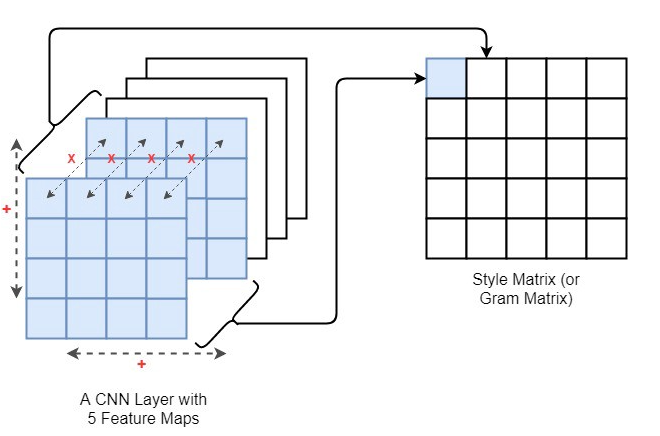

In [ ]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x[0], -1)))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

In [ ]:
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  x = tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
  return x

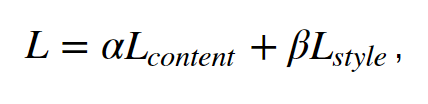

# Hasil ChatGPT

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
content_weight = 1e3
style_weight = 1e-2
total_variation_weight = 1e-4

img_nrows = 512
img_ncols = 512

content_layer_name = 'block5_conv2'
style_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]


In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

style_extractor = vgg_layers(style_layer_names)
feature_extractor = model(inputs=model.input, outputs=style_extractor(model.output))

In [ ]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

base_image_path = "/WhatsApp Image 2023-11-19 at 11.12.56.jpeg"
style_reference_image_path = "/WhatsApp Image 2023-11-19 at 11.12.55.jpeg"

base_image = load_and_preprocess_image(base_image_path)
style_reference_image = load_and_preprocess_image(style_reference_image_path)
combination_image = tf.Variable(load_and_preprocess_image(base_image_path))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have the paths to your base, style, and combination images
base_image_path = "path/to/base_image.jpg"
style_reference_image_path = "path/to/style_reference_image.jpg"
combination_image_path = "path/to/combination_image.jpg"

# Load and preprocess images
def preprocess_image(image_path, target_size=(img_nrows, img_ncols)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Preprocess base, style, and combination images
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = preprocess_image(combination_image_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have the paths to your base, style, and combination images
base_image_path = "path/to/base_image.jpg"
style_reference_image_path = "path/to/style_reference_image.jpg"
combination_image_path = "path/to/combination_image.jpg"

# Load and preprocess images
def preprocess_image(image_path, target_size=(img_nrows, img_ncols)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Preprocess base, style, and combination images
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = preprocess_image(combination_image_path)
# Define Hyperparameters
content_weight = 1e3
style_weight = 1e-2
total_variation_weight = 1e-4

img_nrows = 512
img_ncols = 512

content_layer_name = 'block5_conv2'
style_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

# Define the feature extractor
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

style_extractor = vgg_layers(style_layer_names)
feature_extractor = Model(inputs=style_extractor.input, outputs=style_extractor.output)

# Load and preprocess the input images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

base_image_path = "/WhatsApp Image 2023-11-19 at 11.12.56.jpeg"  # Replace with the actual path
style_reference_image_path = "/WhatsApp Image 2023-11-19 at 11.12.55.jpeg"  # Replace with the actual path

base_image = load_and_preprocess_image(base_image_path)
style_reference_image = load_and_preprocess_image(style_reference_image_path)
combination_image = tf.Variable(load_and_preprocess_image(base_image_path))

# Create the model
def get_model():
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    model = Model(inputs=input_tensor, outputs=features)
    return model

model = get_model()

In [ ]:
!pip uninstall gradio
!pip install gradio==2.0.8

In [ ]:
# download image buat tes code apakah bisa berjalan

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:

c_image = load_img(content_path)
s_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(c_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(s_image, 'Style Image')

plt.show()  # Display the plot


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import gradio as gr

# Constants
img_nrows = 400
img_ncols = 400
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1.0
content_layer_name = "block5_conv2"
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
base_image_path = "\\WhatsApp Image 2023-11-19 at 11.12.56.jpeg"
style_image_path = "\\WhatsApp Image 2023-11-19 at 11.12.55.jpeg"

# Load and preprocess images
def preprocess_image(image_path, target_size=(img_nrows, img_ncols)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    return tf.keras.applications.vgg19.preprocess_input(img)

# Model
def vgg_layers(layer_names):
    vgg = VGG19(weights="imagenet", include_top=False)
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return Model(inputs=vgg.input, outputs=outputs)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

# Gradio Interface
def style_transfer(base_image_path, style_image_path):
    base_image = preprocess_image(base_image_path)
    style_image = preprocess_image(style_image_path)
    combination_image = tf.Variable(preprocess_image(base_image_path))  # Initial guess for combination image

    # Display the images using Gradio
    return base_image[0], style_image[0], combination_image.numpy()[0]

# Run Gradio Interface
iface = gr.Interface(fn=style_transfer, inputs=["image", "image"], outputs="image")
iface.launch()

In [ ]:
def get_model():
    global feature_extractor
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    model = Model(inputs=input_tensor, outputs=features)
    return model

model = get_model()

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

optimizer = Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)

    gradients = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(gradients, combination_image)])
    combination_image.assign(tf.clip_by_value(combination_image, clip_value_min=0.0, clip_value_max=255.0))

num_iterations = 1000
for iteration in range(num_iterations):
    train_step()
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.numpy()}")



In [ ]:
!pip install gradio

import gradio as gr

# Define your style transfer function
def style_transfer(base_image, style_image):
    # Load and preprocess the input images
    base_image = load_and_preprocess_image(base_image)
    style_image = load_and_preprocess_image(style_image)

    # Transfer the style
    combination_image.assign(base_image)
    num_iterations = 100
    for iteration in range(num_iterations):
        train_step()

    # Convert the combination image to a PIL image
    combination_image_pil = tf.keras.preprocessing.image.array_to_img(combination_image.numpy()[0])

    # Display the combination image
    return combination_image_pil

# Create a Gradio interface
iface = gr.Interface(
    fn=style_transfer,
    inputs=["image", "image"],
    outputs="image",
    live=True,
    interpretation="default",
    title="Neural Style Transfer",
    description="Transfer the style of one image to another.",
)

# Launch the Gradio interface
iface.launch()


#Testing/demo (gradio) (alle)

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
def process_images(Base, Filter):
    # Your processing logic here
    result = f"Processed images: {Base} and {Filter}"
    return result

iface = gr.Interface(
    fn=process_images,
    inputs=["image", "image"],  # Two input components for images
    outputs="image"  # Output component for text result
)

# Launch the interface
iface.launch()